In [1]:
pip install langdetect

Note: you may need to restart the kernel to use updated packages.


In [2]:
%config Completer.use_jedi = False  # enable code auto-completion
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  #data visualization library
import nltk # stop words

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, mean_squared_error
#from langdetect import detect


In [3]:
df = pd.read_csv('goodreads_data.csv',index_col=0)
df.drop(columns=['Avg_Rating','Num_Ratings','URL'],inplace=True)  # drop unrelevant columns 

df = df.dropna()
df = df.drop_duplicates()

df.columns =['title','author','description','genres']  # rename columns
no_genres = []

df.drop(df[df['genres'] == '[]'].index, inplace = True)

# Print the first 5 rows of the DataFrame 'df'
df.head(5)

,title,author,description,genres
0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"['Classics', 'Fiction', 'Historical Fiction', ..."
1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',..."
2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","['Classics', 'Fiction', 'Romance', 'Historical..."
3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"['Classics', 'Nonfiction', 'History', 'Biograp..."
4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',..."


In [4]:
genres_null = pd.isnull(df["genres"]) 
print(genres_null.count)

author_null = pd.isnull(df['author'])
print(author_null.count)
# There are no null values in the author, genres and description feature.

df['author'].size

<bound method Series.count of 0       False
1       False
2       False
3       False
4       False
        ...  
9993    False
9994    False
9995    False
9997    False
9998    False
Name: genres, Length: 8973, dtype: bool>
<bound method Series.count of 0       False
1       False
2       False
3       False
4       False
        ...  
9993    False
9994    False
9995    False
9997    False
9998    False
Name: author, Length: 8973, dtype: bool>


8973

The number of distinct genres in the list is: 617

15 most popular genres in the list: 


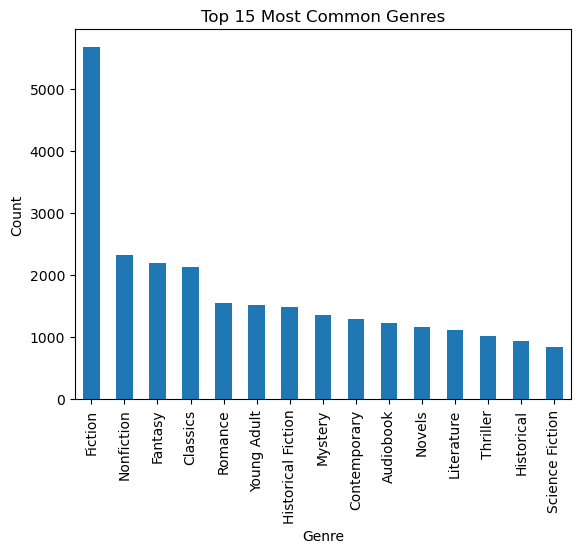

In [5]:
genres = []

for t in df['genres']:         # Extracting genres from the string
    for genre in t.strip("[]").split(","):
        genres += [genre.strip(" ' ")]

num = len(set(genres))
print(f"The number of distinct genres in the list is: {num}")
print()

#plot the 15 most popular genres 
print("15 most popular genres in the list: ")
count = pd.Series(genres).value_counts()[:15]
count.plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Top 15 Most Common Genres')
plt.show()

In [6]:
fiction = list()
nonfiction = list()

# map fiction and non-fiction
def map_genre(genres, genre_name, list_name):
    if genre_name in genres:
        list_name.append(1)
    else:
        list_name.append(0)

for t in df["genres"]:         # Extracting genres from the string
    genres_two = []
    for genre in t.strip("[]").split(","):
        genres_two += [genre.strip(" ' ")]
    map_genre(genres_two,'Fiction', fiction)
    map_genre(genres_two, 'Nonfiction', nonfiction)

df['fiction'] = fiction
df['nonfiction'] = nonfiction

df.head()

,title,author,description,genres,fiction,nonfiction
0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"['Classics', 'Fiction', 'Historical Fiction', ...",1,0
1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",1,0
2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","['Classics', 'Fiction', 'Romance', 'Historical...",1,0
3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"['Classics', 'Nonfiction', 'History', 'Biograp...",0,1
4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',...",1,0


In [7]:
df['either'] = df['fiction'] | df['nonfiction']
df = df[df['either'] == True]

Number of ficion books: 5667
Number of non-ficion books: 2319


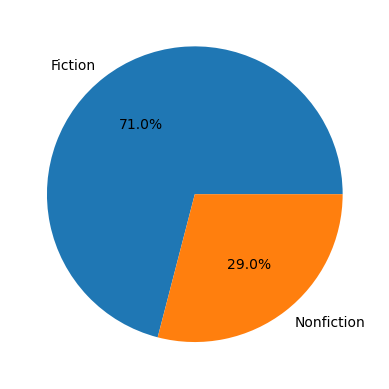

In [8]:
labels = ['Fiction', 'Nonfiction']

fiction1 = df['fiction'] 

fiction_len = sum(1 for i in fiction1 if i == 1)
nonfiction_len = sum(1 for i in fiction1 if i == 0)
data = [fiction_len, nonfiction_len]
 
# Creating plot

fig, ax = plt.subplots()
ax.pie(data, labels=labels, autopct='%1.1f%%')

print(f"Number of ficion books: {fiction_len}")
print(f"Number of non-ficion books: {nonfiction_len}")
    
# show plot
plt.show()

In [9]:
from langdetect import detect

def detect_lang(text):
    try:
        return detect(text)
    except:
        return 'unknown language'

df['detect_language'] = df['description'].apply(detect_lang)
df = df[df['detect_language'] == 'en']
df.head()

print(f"Number of data points left after preprocessing: {len(df)}")

Number of data points left after preprocessing: 7745


In [10]:
df.drop(['genres','either','nonfiction', 'detect_language'], axis = 1, inplace = True)

In [11]:
# features preprocessing 
# lowercase the description and authors' names
df['description'] = df['description'].str.lower()
df['author'] = df["author"].str.lower()

#remove punctuation
import string
def remove_punctuation(text):
    translator = str.maketrans("", "", string.punctuation)
    # Apply the translation thingy to the input string
    return text.translate(translator)

df["description"] = df["description"].apply(remove_punctuation)

df.head()

,title,author,description,fiction
0,To Kill a Mockingbird,harper lee,the unforgettable novel of a childhood in a sl...,1
1,Harry Potter and the Philosopher’s Stone (Harr...,j.k. rowling,harry potter thinks he is an ordinary boy unt...,1
2,Pride and Prejudice,jane austen,since its immediate success in 1813 pride and ...,1
3,The Diary of a Young Girl,anne frank,discovered in the attic in which she spent the...,0
4,Animal Farm,george orwell,librarians note there is an alternate cover ed...,1


In [12]:
#remove stopwords + lemmatization
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['bestselling', 'author', 'book','bestseller','new york', 'york times','york'])

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

df["description"] = df["description"].apply(remove_stopwords).apply(lemmatizer.lemmatize)
df.head()
# A function to remove stopwords    

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/nguyent119/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nguyent119/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,author,description,fiction
0,To Kill a Mockingbird,harper lee,unforgettable novel childhood sleepy southern ...,1
1,Harry Potter and the Philosopher’s Stone (Harr...,j.k. rowling,harry potter thinks ordinary boy rescued owl t...,1
2,Pride and Prejudice,jane austen,since immediate success 1813 pride prejudice r...,1
3,The Diary of a Young Girl,anne frank,discovered attic spent last years life anne fr...,0
4,Animal Farm,george orwell,librarians note alternate cover edition editio...,1


In [13]:
# create the features and labels array
X = np.array(df['description'])

y = np.array(df['fiction'])

X
y

array([1, 1, 1, ..., 0, 1, 1])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Data distribution:\n- Train: {} \n- Validation: {} \n- Test: {}".format(len(y_train),len(y_val),len(y_test)))

vectorizer = TfidfVectorizer(min_df = 0.014, max_df = 0.8, ngram_range = (1, 2))
X_train_rf_tfidf = vectorizer.fit_transform(X_train)
X_val_rf_tfidf = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)
vectorizer.get_feature_names_out()
    
print('vocab size/number of features:', len(vectorizer.idf_))

Data distribution:
- Train: 4956 
- Validation: 1240 
- Test: 1549
vocab size/number of features: 1021


In [15]:
# validation
estimators = [2,4,6,8]    

# we will use this variables to store the resulting training and validation errors for each depth
forest_tr_acc = []          
forest_val_acc = []
for e in estimators:    # use for-loop to fit random forest models with different depths
    clf_rf = RandomForestClassifier(n_estimators = e, criterion = 'gini', max_depth=30, random_state = 20, class_weight = "balanced") 
    clf_rf.fit(X_train_rf_tfidf, y_train)    # apply random forest to these new features and labels
  
    y_pred_train = clf_rf.predict(X_train_rf_tfidf)    # predict using the rf model
    tr_acc = accuracy_score(y_train, y_pred_train)
    #X_val_rf = clf_rf.fit(X_val_tfidf, y_val) # transform the raw features for the validation data 
    y_pred_val = clf_rf.predict(X_val_rf_tfidf) # predict values for the validation data using the random forest model 
    val_acc = accuracy_score(y_val, y_pred_val)
 
    forest_tr_acc.append(tr_acc)
    forest_val_acc.append(val_acc)

In [16]:
accuracy = {"estimator":estimators,
          "rf training accuracy":forest_tr_acc,
          "rf validation accuracy":forest_val_acc,
         }
print(pd.DataFrame({ key:pd.Series(value) for key, value in accuracy.items()}))

from statistics import mean 
print()

print(f"Averrage training accuracy: {mean(forest_tr_acc)}")
print(f"Averrage validation accuracy: {mean(forest_val_acc)}")

   estimator  rf training accuracy  rf validation accuracy
0          2              0.888418                0.772581
1          4              0.939669                0.806452
2          6              0.956013                0.820968
3          8              0.962873                0.831452

Averrage training accuracy: 0.9367433414043583
Averrage validation accuracy: 0.8078629032258065


In [17]:
# model: Random forest

clf = RandomForestClassifier(n_estimators = 8, criterion = 'gini', max_depth=30, random_state = 20, class_weight = "balanced")
clf.fit(X_train_rf_tfidf, y_train)
y_pred_rf = clf.predict(X_test_tfidf)

Accuracy of random forest: 0.8347320852162685


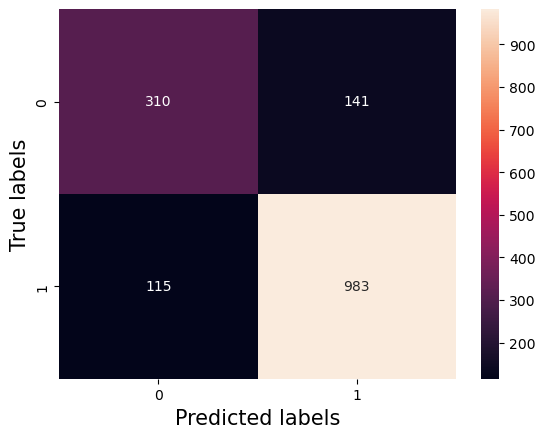

In [18]:
acc = accuracy_score(y_test, y_pred_rf)
confmat = confusion_matrix(y_test, y_pred_rf)

print("Accuracy of random forest:", acc)

# plot the confusion matrix
ax = plt.subplot()
sns.heatmap(confmat,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
plt.show()

In [19]:
#using logistic Regression
lr_tr_acc = []
lr_val_acc = []

#using the description to create a tf-idf feature matrix 
X_train_lr_tfidf = vectorizer.fit_transform(X_train)
X_val_lr_tfidf = vectorizer.transform(X_val)

# initilaize the method
clf = LogisticRegression()
clf.fit(X_train_lr_tfidf, y_train)
y_pred_train = clf.predict(X_train_lr_tfidf)
tr_acc = accuracy_score(y_train, y_pred_train) #validation

y_pred_val = clf.predict(X_val_lr_tfidf)
val_acc = accuracy_score(y_val, y_pred_val) 

lr_tr_acc.append(tr_acc)
lr_val_acc.append(val_acc)

In [20]:
#accuracy = {"n": range(1,6),
#          "lr training accuracy":lr_tr_acc,
#          "lr validation accuracy":lr_val_acc,
#         }
#pd.DataFrame({ key:pd.Series(value) for key, value in accuracy.items()})

print(f"Training accuracy: {tr_acc}")
print(f"Validation accuracy: {val_acc}")

Training accuracy: 0.9227199354317999
Validation accuracy: 0.8943548387096775


In [21]:
#test

#X_train_lr_tfidf = vectorizer.fit_transform(X_train_lr)
#X_test_tfidf  = vectorizer.transform(X_test)

clf.fit(X_train_lr_tfidf, y_train)
y_pred_2 = clf.predict(X_test_tfidf)
                                                                           

Accuracy of logistic regression: 0.8967075532601678
[[ 332  119]
 [  41 1057]]


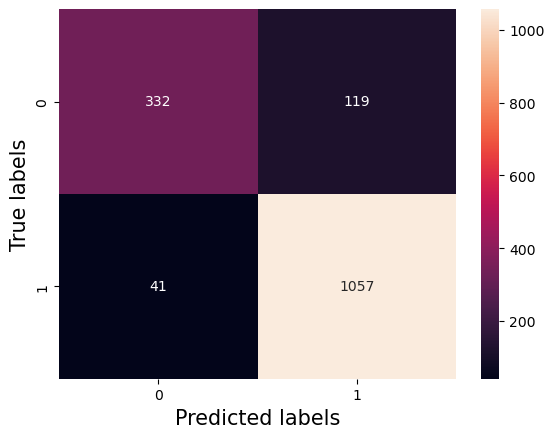

In [22]:
acc = accuracy_score(y_test, y_pred_2)
print("Accuracy of logistic regression:", acc)

conf_mat_2 = confusion_matrix(y_test, y_pred_2)
print(conf_mat_2) #print the confusion matrix

sns.heatmap(conf_mat_2, annot=True, fmt='g', ax=ax)

ax = plt.subplot()
sns.heatmap(conf_mat_2,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
plt.show()